# Training and evaluating encoding models

In [ ]:
import mne
import h5py
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nilearn.plotting import plot_markers
from mne_bids import BIDSPath

from himalaya.backend import set_backend, get_backend
from himalaya.ridge import RidgeCV
from himalaya.scoring import correlation_score

from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from neuro import config
from os.path import join
import joblib
from tabpfn import TabPFNRegressor
from tqdm import tqdm

if torch.cuda.is_available():
    set_backend("torch_cuda")
    print("Using cuda!")

## Loading features

We will now load two contextual word embeddings from GPT-2 ([Radford et al., 2019](https://cdn.openai.com/better-language-models/language_models_are_unsupervised_multitask_learners.pdf)). The loaded features should be a numpy array with a shape of (number of tokens * feature dimensions). Note that the numbers of tokens are different for the two features because of different tokenization schemas.

In [ ]:
bids_root = join(config.ECOG_DIR, 'podcasts_data', 'ds005574')
# Download the transcript, if required
embedding_path = join(bids_root, 'stimuli/gpt2-xl/features.hdf5')

In [ ]:
modelname, layer = 'gpt2-xl', 24
with h5py.File(embedding_path, "r") as f:
    contextual_embeddings = f[f"layer-{layer}"][...]
print(f"LLM embedding matrix has shape: {contextual_embeddings.shape}")

We will also load the stimuli transcripts associated with these features. Both transcripts should contain information about the word, token, start (onset), and end (offset). The contextual word embedding transcript should also include other prediction information extracted from GPT-2, like rank, probability, and entropy. For instance, we can calculate how accurate the model is in predicting the next token in the transcript based on the `rank` column, which are integers that represents the rank of the actual token in all the possible tokens of GPT-2.

Note: Check that the transcript contains the same number of tokens as the features we loaded before.

In [ ]:
# Download the transcript, if required
transcript_path = join(bids_root, "stimuli/gpt2-xl/transcript.tsv")

# Load transcript
df_contextual = pd.read_csv(transcript_path, sep="\t", index_col=0)
if "rank" in df_contextual.columns:
    model_acc = (df_contextual["rank"] == 0).mean()
    print(f"Model next-token prediction accuracy: {model_acc*100:.3f}%")

df_contextual.head()

When we extracted features, some words are split into separate tokens. Since we only have information of start and end for words, we will align the features from tokens to words for encoding models. Here, we simply average the token features across the same word. Now the features should be a numpy array with a shape of (number of words * feature dimensions).

In [ ]:
aligned_embeddings = []
for _, group in df_contextual.groupby("word_idx"):  # group by word index
    indices = group.index.to_numpy()
    average_emb = contextual_embeddings[indices].mean(0)  # average features
    aligned_embeddings.append(average_emb)
aligned_embeddings = np.stack(aligned_embeddings)
print(f"LLM embeddings matrix has shape: {aligned_embeddings.shape}")

We will also construct a dataframe containing words with their start and end timestamps.

In [ ]:
df_word = df_contextual.groupby("word_idx").agg(
    dict(word="first", start="first", end="last"))
df_word.head()

## Loading brain data

Next, we will load the preprocessed high-gamma ECoG data using MNE. Here, we will demonstrate loading data from our third subject.

In [ ]:
file_path = BIDSPath(root=join(bids_root, "derivatives/ecogprep"),
                     subject="03", task="podcast", datatype="ieeg", description="highgamma",
                     suffix="ieeg", extension=".fif")
print(f"File path within the dataset: {file_path}")

raw = mne.io.read_raw_fif(file_path, verbose=False)
picks = mne.pick_channels_regexp(raw.ch_names, "LG[AB]*")
raw = raw.pick(picks)
raw

We will map the start information (in seconds) of each word in the dataframe onto the brain signal data by multiplying by the sampling rate. Here the first column of `events` mark the start of each word on the brain signal data.

In [ ]:
events = np.zeros((len(df_word), 3), dtype=int)
events[:, 0] = (df_word.start * raw.info['sfreq']).astype(int)
events.shape

Then we'll take advantage of MNE's tools for creating epochs around stimulus events, which here are the starts (onsets) of each word, to visualize brain signal that respond to word onsets. Here, we take a fixed-width window ranging from -2 seconds to +2 seconds relative to word onset. Since the sampling rate is 512 Hz (512 samples per second), we have 2049 lags total. The ECoG data is a numpy array with the shape of (number of words * number of ECoG electrodes * number of lags).

In [ ]:
# epochs = mne.Epochs(
#     raw,
#     events,
#     tmin=-2.0,
#     tmax=2.0,
#     baseline=None,
#     proj=False,
#     event_id=None,
#     preload=True,
#     event_repeated="merge",
# )
# print(f"Epochs object has a shape of: {epochs._data.shape}")

# epochs = epochs.resample(sfreq=32, npad='auto',
#                          method='fft', window='hamming', n_jobs=128)
# print(f"Epochs object has a shape of: {epochs._data.shape}")
# joblib.dump(epochs, 'epochs_tmp.joblib')

In [ ]:
def tabpfn_fit_multiple_outputs_and_predict(X_train, Y_train, X_test):
    """
    Fit TabPFNRegressor to multiple outputs.
    """
    Y_test = np.zeros((X_test.shape[0], Y_train.shape[1]))
    model = TabPFNRegressor(device='cuda')
    for i in tqdm(range(Y_train.shape[1])):
        model.fit(X_train, Y_train[:, i])
        Y_test[:, i] = model.predict(X_test)
    return Y_test


def get_time_feats(df):
    df_time_feats = df[['start', 'end']]

    # normalize start and end cols
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    df_time_feats['start'] = scaler.fit_transform(df_time_feats[['start']])
    df_time_feats['end'] = scaler.fit_transform(df_time_feats[['end']])

    df_time_feats['wordlen'] = df_time_feats['end'] - df_time_feats['start']
    df_time_feats['word_gap'] = (df_time_feats['start'].shift(
        1) - df_time_feats['end'].shift(1)).fillna(0)
    return df_time_feats.values.astype(np.float32)

In [102]:
# set up data
model_type = 'ridge'
feat_type = 'time'
n_features = -1
n_output_electrodes = 30


# get data proper
epochs = joblib.load('epochs_tmp.joblib')
epochs_data = epochs.get_data(copy=True)
if n_output_electrodes > 0:
    epochs_data = epochs_data[:, :n_output_electrodes, :]
n_timepoints, n_electrodes, n_lags = epochs_data.shape


# flatten electrodes and lags
epochs_data = epochs_data.reshape(len(epochs), -1)
print(f"ECoG data matrix shape: {epochs_data.shape}")

# select feats
selected_df = df_word.iloc[epochs.selection]

if feat_type == 'time':
    X = get_time_feats(selected_df)
elif feat_type == 'word':
    averaged_embeddings = aligned_embeddings[epochs.selection]
    X = averaged_embeddings.astype(np.float32)
Y = epochs_data.astype(np.float32)

if n_features > 0:
    X = X[:, :n_features]  # select first n_features

# set up model
alphas = np.logspace(1, 10, 10)  # specify alpha values
# inner 5-fold cross-validation setup
inner_cv = KFold(n_splits=5, shuffle=False)
model = make_pipeline(
    StandardScaler(),
    RidgeCV(alphas, fit_intercept=True, cv=inner_cv)  # pipeline
)


corrs = []  # empty array to store correlation results
kfold = KFold(2, shuffle=False)  # outer 2-fold cross-validation setup
for train_index, test_index in kfold.split(X):  # loop through folds

    # Split train and test datasets
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]

    # Standardize Y
    scaler = StandardScaler()
    Y_train = scaler.fit_transform(Y_train)
    Y_test = scaler.transform(Y_test)

    # Fit pipeline with transforms and ridge estimator
    if model_type == 'ridge':
        model.fit(X_train, Y_train)
        Y_preds = model.predict(X_test)
    elif model_type == 'tabpfn':
        Y_preds = tabpfn_fit_multiple_outputs_and_predict(
            X_train, Y_train, X_test)
    corr = correlation_score(Y_test, Y_preds).reshape(
        n_electrodes, n_lags)  # Compute correlation score

    if "torch" in get_backend().__name__:  # if using gpu, transform tensor back to numpy
        corr = corr.numpy(force=True)

    corrs.append(corr)  # append fold correlation results to final results
corrs_embedding = np.stack(corrs)


# set_backend("torch") # resort to torch or numpy if cuda out of memory
# corrs_embedding = train_encoding(X, Y)
print(
    f"Encoding performance correlating matrix shape: {corrs_embedding.shape} [this is n_folds, n_electrodes, n_lags]")
print('max of means', corrs_embedding.mean(axis=(0, 1)).max())

ECoG data matrix shape: (5130, 3840)


/tmp/ipykernel_1187737/2875586186.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_feats['start'] = scaler.fit_transform(df_time_feats[['start']])
/tmp/ipykernel_1187737/2875586186.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_time_feats['end'] = scaler.fit_transform(df_time_feats[['end']])


Encoding performance correlating matrix shape: (2, 30, 128) [this is n_folds, n_electrodes, n_lags]
max of means 0.008736983


## Plotting encoding performance

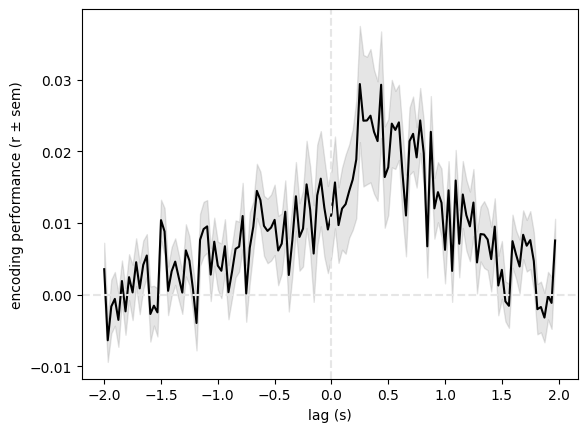

In [99]:
lags = np.arange(-2 * 512, 2 * 512, 16) / 512  # specify the lags
mean = corrs_embedding.mean(axis=(0, 1))
err = corrs_embedding.std(axis=(0, 1)) / \
    np.sqrt(np.prod(corrs_embedding.shape[:2]))

fig, ax = plt.subplots()
ax.plot(lags, mean, color='black')
ax.fill_between(lags, mean - err, mean + err, alpha=0.1, color='black')
ax.set_xlabel("lag (s)")
ax.set_ylabel("encoding performance (r ± sem)")
ax.axvline(0, c=(.9, .9, .9), ls="--")
ax.axhline(0, c=(.9, .9, .9), ls="--")
fig.show()

Next we summarize temporally by selecting the maximum correlation across lags per electrode. Now that we have one correlation per electrode, we plot the results on the brain.

In [ ]:
values = corrs_embedding.mean(0).max(-1)

ch2loc = {ch['ch_name']: ch['loc'][:3] for ch in raw.info['chs']}
coords = np.vstack([ch2loc[ch] for ch in raw.info['ch_names']])
coords *= 1000  # nilearn likes to plot in meters, not mm
print("Coordinate matrix shape: ", coords.shape)

order = values.argsort()
plot_markers(values[order], coords[order],
             node_size=30, display_mode='lzr',
             node_vmin=0, node_cmap='inferno_r', colorbar=True)
plt.show()